<a href="https://colab.research.google.com/github/MohamadMahdiDarvishi/Tensorflow/blob/main/Notebooks/Tensorflow_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3 : Time series forecasting in TensorFlow (BitPredict 💰📈)

## 0. Prerequirities

In [ ]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
from tensorflow.keras.utils import plot_model

In [ ]:
# Check GPU Access
!nvidia-smi

Mon Mar  4 15:20:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

In [ ]:
# Downloading bitcoin data from github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-03-04 15:20:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2024-03-04 15:20:36 (10.4 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



❗ **Note**

Remember to put webpage on raw mode for downloading data

**Taking a Glance at our data**

In [ ]:
# looking through data
df_test = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv" ,
                      parse_dates = ["Date"] , # makes parsing the data much faster in some cases
                      index_col = ["Date"]) # makes columns indexed by Date column
df_test.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
# checking number of samples
len(df_test)

2787

In [ ]:
# a overview of our data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# visualizing a column based on dates
bitcoin_price = pd.DataFrame(df_test["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)" : "price"})
bitcoin_price.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


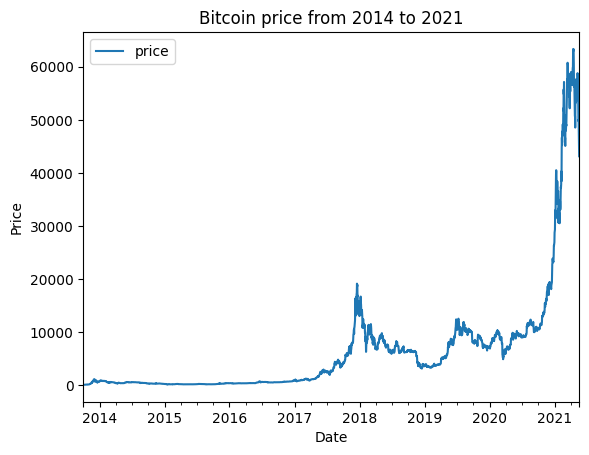

In [ ]:
bitcoin_price.plot() ;
plt.ylabel("Price") ;
plt.title("Bitcoin price from 2014 to 2021" , fontsize = 12) ;

using `csv` and `datetime` module for taking a look at our data

In [ ]:
# imports
import csv
from datetime import datetime

# opening file

time_steps = []
prices = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv" , "r") as f :
  csv_reader = csv.reader(f , delimiter = ",") # delimiter is used for seperating data columns
  next(csv_reader)
  for line in csv_reader :
    time_steps.append(datetime.strptime(line[1] , "%Y-%m-%d"))
    prices.append(float(line[2]))

time_steps[:5] , prices[:5]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0)],
 [123.65499, 125.455, 108.58483, 118.67466, 121.33866])

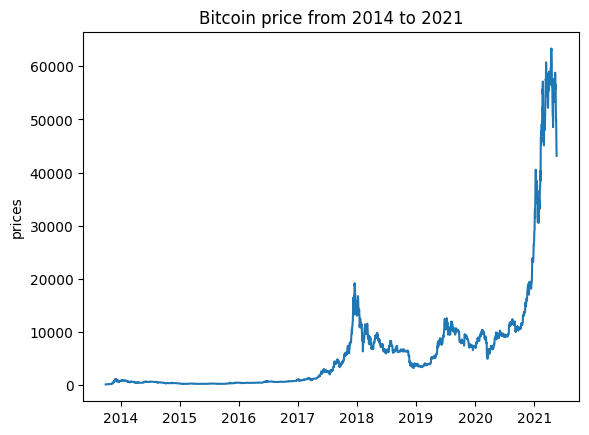

In [ ]:
plt.plot(time_steps , prices) ;
plt.ylabel("prices") ;
plt.title("Bitcoin price from 2014 to 2021") ;

**Turning data to window and Horizons**

Windowing is a method to turn a time series dataset into **supervised learning problem**

In other words, we want to use windows of the past to predict the future

❗ **Attention**

the term of window and horizon is discussed in further sections

then we are going to write a functions to

1. Make our windows lablled
2. Turning our datasets to windows and then Making them lablled  

In [ ]:
def get_lablled_windows(x , horizon=1) :
  """
  Create labels for windowed datasets

  E.g.
  Input : [0,1,2,3,4,5,6,7] -> Output : [0,1,2,3,4,5,6] , [7]
  """
  window , label = x[: , :-horizon] , x[:, -horizon:]
  return window , label

In [ ]:
# Testing get_lablled_windows function
test = np.expand_dims(np.arange(8) ,axis = 0)
window , label = get_lablled_windows(x=test)
print(f"Input : {test[0]}   -> Output  :  \nwindow : {window[0]}   ,  label : {label[0]}")

Input : [0 1 2 3 4 5 6 7]   -> Output  :  
window : [0 1 2 3 4 5 6]   ,  label : [7]


In [ ]:
# Make global variables
WINDOW_SIZE = 7
HORIZON_SIZE = 1
# defining the function
def make_windows(x , window_size , horizon=1) :
  # 1. Creating the first window
  window_step = np.expand_dims(np.arange(window_size+horizon) ,axis = 0)
  # 2. Making window indexes
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)),axis = 0).T
  # 3. indexing the input vector for creating the windows
  windows = (np.array(x))[window_indexes]
  # 4. make windows labled
  window , label = get_lablled_windows(windows , horizon = horizon)

  return window , label

as the code above is much difficult to understand we would look through every step

In [ ]:
# making an sample array of data
x = list(range(16))
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
# 1. Creating the first window
window_step = np.expand_dims(np.arange(WINDOW_SIZE+HORIZON_SIZE),axis = 0)
window_step

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [ ]:
# 2. Making window indexes
test = np.expand_dims(np.arange(len(x) - (WINDOW_SIZE + HORIZON_SIZE-1)) , axis = 0).T
test

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [ ]:
# 3. indexing the input vector for creating the windows
window_step + test

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [ ]:
# testing make_windows function
window , label = make_windows(x=prices , window_size=7 , horizon = 1)
len(window) , len(label)

(2780, 2780)

In [ ]:
import random
random_indexes  = random.sample(population = list(np.arange(len(window))) , k = 3)
for i in range(len(random_indexes)) :
  print(f"WINDOW  :  {(window[random_indexes[i]]).round(2)}  ,  LABEL  :  {label[random_indexes[i]][0]:.3f}")

WINDOW  :  [3578.21 3391.87 3452.62 3507.31 3419.73 3360.95 3414.83]  ,  LABEL  :  3263.548
WINDOW  :  [1216.27 1187.14 1186.11 1189.55 1184.2  1211.74 1218.67]  ,  LABEL  :  1227.981
WINDOW  :  [3606.16 3611.53 3497.67 3654.35 3568.75 3593.72 3623.72]  ,  LABEL  :  3605.855


**Turning Windows into training and test sets**

❗ **Note**

it's better to window our data then turn them into train and test data sets

let's write a function to do the job for us !

In [ ]:
# window_to_train_test function
def window_to_train_test(windows , labeles , test_split_size = 0.2) :
  split_border = int(len(windows) * (1-test_split_size))
  train_windows = windows[:split_border]
  train_lables = labeles[:split_border]
  test_windows = windows[split_border:]
  test_lables = labeles[split_border:]

  return train_windows , train_lables , test_windows , test_lables

In [ ]:
# let's check our function
train_windows , train_lables , test_windows , test_lables = window_to_train_test(windows=window , labeles=label)
len(train_windows) , len(train_lables) , len(test_windows) , len(test_lables)

(2224, 2224, 556, 556)

In [ ]:
window[0] , train_windows[0]

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]))

**Turnning data to training and test splits**

❗ **Note**

we could not use `train_test_split` function from skit-learn to split dataset to train and test datasets as this function uses randomise functionality for spliting data and this means that we would have test data between train data and that is against the criteria of time series models

🗒 **Point**

in time series models we are trying to train our model on past data to make model capable of making prediction on future data so it depicts that test split must be placed at the end of our data sets (as dataset starts from past and continued to the future)


In [ ]:
# Creating train and test split size
split_size = int(len(time_steps)*0.8)
# making training data and lables
X_train , y_train = time_steps[:split_size] , prices[:split_size]
# making test data and lables
X_test , y_test = time_steps[split_size:] , prices[split_size:]
# a closer look at train and test data
len(X_train) , len(X_test)

(2229, 558)

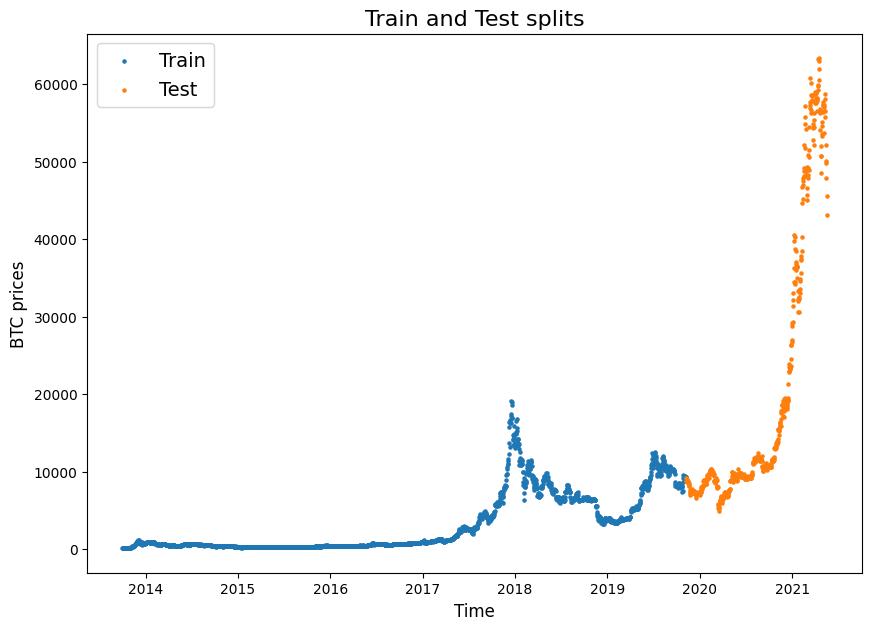

In [ ]:
# visualize train and test data
plt.figure(figsize = (10,7)) ;
plt.scatter(X_train , y_train , s = 5 , label = "Train") ;
plt.scatter(X_test , y_test , s = 5 , label = "Test") ;
plt.xlabel("Time" , fontsize = 12) ;
plt.ylabel("BTC prices" , fontsize = 12) ;
plt.legend(fontsize = 14) ;
plt.title("Train and Test splits" , fontsize = 16) ;
plt.show() ;

**Create a function to plot time-series dataset**

In [ ]:
# time-series functionn
def plot_time_series(timesteps , values  , format='.', start=0 ,end=None , label = None) :
  """
  preventing of writing matplotlib.pyplot codes for visualizing data

  parameters
  ------------------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (an offset value for function to start from for plotting)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values

  """
  plt.plot(timesteps[start:end] , values[start:end] , format , label=label)
  plt.xlabel("Time" , fontsize = 12)
  plt.ylabel("Price" , fontsize = 12)
  if label :
    plt.legend(fontsize = 14)
  plt.grid(True)

## 2. Building models

There is **two important terms** about time-series models :

* **hrizon** - number of timesteps to predict in future
* **window** - number of timesteps from past used for making predictions about future


We would test different models for finding the best model based on result

**Write a function make model checkpoint**

as model results fluctuate , we want to compare model's best performance against another model's best performance so we make checkpoint model callback for making checkpoints of our best model performance .

In [ ]:
# create_model_checkpoint function
import os
def create_model_checkpoint(model_name , save_path = "Experiments") :
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_path , model_name),
                                            verbose = 0 ,
                                            save_best_only =True)

### 2.0 Model 0 : Naive Forecast

(baseline)

**Nive Forcasting**  - one of the most common **baseline** models for time-series forecasting

what all naive models does is to use previous timestep values to predict next timesteps values the formula would be like this :

$$\hat{y_t}=y_{t-1}$$



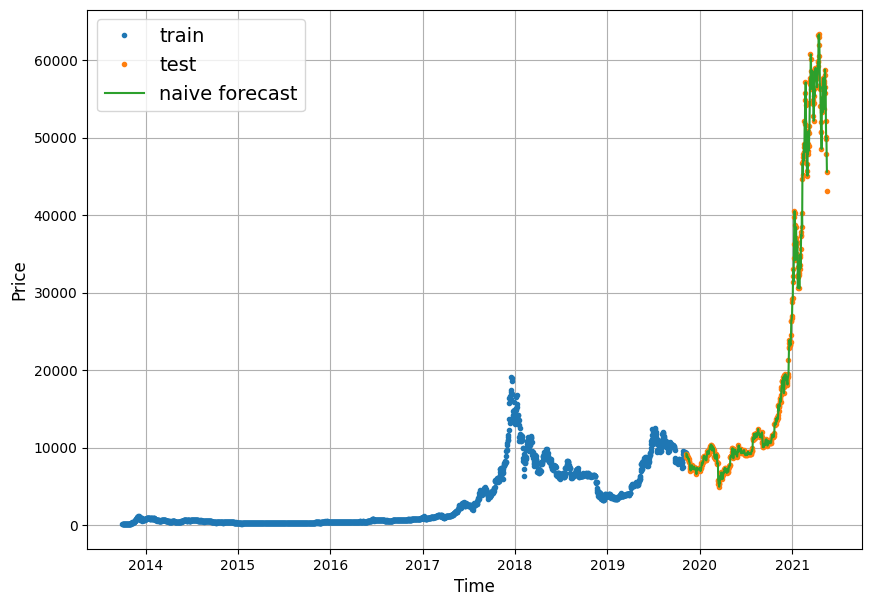

In [ ]:
# Create a naive forecast
naive_forecast  = y_test[:-1]
# plot a naive forecast
plt.figure(figsize = (10,7)) ;
plot_time_series(X_train , y_train , label = "train")
plot_time_series(X_test , y_test , label = "test")
plot_time_series(X_test[1:] , y_test[:-1] , format = "-" , label = "naive forecast")

❗ **Note**

if we take a closer look at figure we could see that our test plot is shifted 1 unity to the left as we use the last data for making predictions in naive model

**Evaluating a time-series model**

a time-series forecasting model is kind of a **Regression** model as we are working with numbers .

The main thing we will be evaluating is:

 *how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)*?

**Scale-dependent errors**

* MAE - Mean Absolute Error
* RMSE - Root Mean Square Error

**Percentage errors**

* MAPE - Mean Absolute Percentage Error
* sMAPE - symmetric Mean Absolute Percentage Error

**Scaled errors**

* MASE - Mean Absolute Scaled Error

❗ **Note**

for all of above metrics **lower is better**

❓ **There is many Metrics which one should we use ?**

it depends on kind of problem we are going to work on but it's usual to use MAE



In [ ]:
# let's write a function for evaluating metrics on models
def evaluate_preds(y_true , y_pred) :
  # casting dtype of prediction and lables
  y_pred = tf.cast(y_pred , dtype = tf.float32)
  y_true = tf.cast(y_true , dtype = tf.float32)

  # calculating MASE
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  naive_mae = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1]))
  mase = mae/naive_mae

  # calculating other metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  # returning results
  results = { "mae" : mae.numpy() ,
              "mse" : mse.numpy() ,
              "rmse": rmse.numpy() ,
              "mape": mape.numpy() ,
              "mase": mase.numpy() }
  return results

In [ ]:
# calculating on naive baseline model
naive_forecast = y_test[:-1]
naive_results = evaluate_preds(y_test[1:] , naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.69212395}

❗ **Note**

when the `MAE` metric is equal to 567 \$ it means that our predictions have a mean absolute error of 567 \$

### 2.1 Model 1 : Dense Model
(Window = 7 , Horizon = 1)

In [ ]:
tf.random.set_seed(42)
# Create model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128 , activation = "relu" , name = "input_layer") ,
    tf.keras.layers.Dense(HORIZON_SIZE , activation = "linear", name = "output_layer")
] , name = "model_1")
# Compile model

model_1.compile(
    loss = tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam() ,
    metrics = ["mae"]
)
# Fit model
model_1.fit(x = train_windows ,
            y = train_lables ,
            epochs = 100 ,
            verbose = 1 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_lables) ,
            callbacks = create_model_checkpoint(model_name = model_1.name))

Epoch 1/100
18/18 [==============================] - 2s 43ms/step - loss: 2612.0793 - mae: 2612.0793 - val_loss: 5641.1562 - val_mae: 5641.1562
Epoch 2/100
18/18 [==============================] - 0s 24ms/step - loss: 402.3164 - mae: 402.3164 - val_loss: 1105.9198 - val_mae: 1105.9198
Epoch 3/100
18/18 [==============================] - 1s 34ms/step - loss: 223.0426 - mae: 223.0426 - val_loss: 1076.6462 - val_mae: 1076.6462
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 195.1891 - mae: 195.1891 - val_loss: 1046.2179 - val_mae: 1046.2179
Epoch 5/100
18/18 [==============================] - 1s 43ms/step - loss: 187.0892 - mae: 187.0892 - val_loss: 1026.4208 - val_mae: 1026.4207
Epoch 6/100
18/18 [==============================] - 1s 42ms/step - loss: 180.2563 - mae: 180.2563 - val_loss: 1001.8624 - val_mae: 1001.8624
Epoch 7/100
18/18 [==============================] - 1s 40ms/step - loss: 175.2141 - mae: 175.2141 - val_loss: 974.3877 - val_mae: 974.3877
Epoch 

❗ **Note**

we know that as we evaluate our model the result of last epoch would be proceeded not the best results so we must use our model checkpoints

In [ ]:
model_1_loaded = tf.keras.models.load_model("Experiments/model_1")
model_1_loaded.evaluate(test_windows , test_lables)

18/18 [==============================] - 0s 4ms/step - loss: 570.3393 - mae: 570.3393


[570.3392944335938, 570.3392944335938]

**Making prediction with Models**

for automation let's write a function that :

1. Takes a trained model
2. Takes evaluation data
3. Make prediction on evaluation data
4. Return predictions

⚡ **Tip**

*forecasting* is different from making prediction , in forecasting we make prediction on the future data while in making predictions we make prediction on available data


In [ ]:
# make_pred function
def make_pred(model , evaluation_data) :
  """
  this function takes a trained model and evaluation data then makes predictions on them

  Parameters
  --------------
  model :  a trained model
  evaluation_data : the test data to make predictions on them

  """
  model_preds = tf.squeeze(model.predict(evaluation_data , verbose = 0))

  return model_preds

In [ ]:
# let's test our function
model_1_preds = make_pred(model_1_loaded , test_windows)
model_1_preds[:10].numpy()

array([8844.31 , 8765.184, 9013.969, 8773.643, 8714.786, 8697.815,
       8689.397, 8493.875, 8441.981, 8508.851], dtype=float32)

Now we could use our prediction's to evaluate our model

In [ ]:
# Evaluating model 1
model_1_results = evaluate_preds(y_pred= model_1_preds,
                                 y_true= tf.squeeze(test_lables))
model_1_results

{'mae': 570.33936,
 'mse': 1175130.9,
 'rmse': 1084.0345,
 'mape': 2.5520675,
 'mase': 0.6908745}

### 2.2 Model 2 : Dense Model

(Window = 30 , Horizon  = 1)

In [ ]:
# global variables
WINDOW_SIZE = 30
HORIZON_SIZE = 1

# Making windows and lables
windows , lables = make_windows(x= prices,
                                window_size = WINDOW_SIZE ,
                                horizon = HORIZON_SIZE)
# Turning   windows to train and test Windows and lables
train_windows , train_lables, test_windows , test_lables = window_to_train_test(windows= windows ,labeles = lables)

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128 , activation = "relu" , name = "input_layer") ,
    tf.keras.layers.Dense(HORIZON_SIZE , activation = "linear" , name = "output_layer")
] , name = "model_2")

# Compile mdoel
model_2.compile(
    loss = tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam()
)

# Fit model
model_2.fit(x = train_windows ,
            y = train_lables ,
            epochs = 100 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_lables) ,
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

Epoch 1/100
18/18 [==============================] - 1s 45ms/step - loss: 2140.5483 - val_loss: 3152.1953
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 563.2869 - val_loss: 2100.4636
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 387.3240 - val_loss: 2126.8005
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 341.9445 - val_loss: 1809.3888
Epoch 5/100
18/18 [==============================] - 0s 23ms/step - loss: 313.5860 - val_loss: 1704.0638
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 302.7094 - val_loss: 1888.6499
Epoch 7/100
18/18 [==============================] - 0s 23ms/step - loss: 285.3380 - val_loss: 1485.6477
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 261.6362 - val_loss: 1634.7570
Epoch 9/100
18/18 [==============================] - 0s 23ms/step - loss: 245.3992 - val_loss: 1352.4971
Epoch 10/100
18/18 [==============================] - 1s 

In [ ]:
# Finding model best results
model_2_loaded = tf.keras.models.load_model("Experiments/model_2")

# making prediction by our model
model_2_pred = make_pred(model = model_2_loaded ,
                         evaluation_data= test_windows)

# evaluating model
# check for models to be on the same shapae  =>  model_2_pred[0].shape == tf.squeeze(test_lables)[0].shape -> True
model_2_results = evaluate_preds(y_true = tf.squeeze(test_lables),
                                 y_pred = model_2_pred)

model_2_results # the mae equals => np.isclose(model_2_loaded.evaluate(test_windows, test_lables , verbose = 0) , model_2_results["mae"]) -> True

{'mae': 649.1835,
 'mse': 1443191.4,
 'rmse': 1201.329,
 'mape': 2.9418476,
 'mase': 0.72068053}

### 2.3 Model 3 : Dense Model

(Window = 30 , Horizon = 7)

In [ ]:
# resetting global variables
WINDOW_SIZE = 30
HORIZON_SIZE = 7

# Making windows and lables
windows , lables = make_windows(x = prices ,
                                window_size = WINDOW_SIZE ,
                                horizon = HORIZON_SIZE)

# Turning windows and lables to train and test
train_windows , train_lables , test_windows , test_lables  = window_to_train_test(windows = windows , labeles = lables)

# checking train and test data sets size
len(train_windows) , len(train_lables) , len(test_windows) , len(test_lables)

(2200, 2200, 551, 551)

In [ ]:
# set random_seed
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128 , activation = "relu" , name = "input_layer") ,
    tf.keras.layers.Dense(HORIZON_SIZE , activation = "linear" , name = "output_layer")
] , name = "model_3")

# Compile model
model_3.compile(
    loss = tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam()
)

# Fit model
model_3.fit(x = train_windows ,
            y = train_lables ,
            epochs = 100 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_lables) ,
            callbacks = [create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 1s 29ms/step - loss: 1980.2864 - val_loss: 3091.5486
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 573.9378 - val_loss: 2482.3396
Epoch 3/100
18/18 [==============================] - 0s 24ms/step - loss: 441.6231 - val_loss: 2179.9666
Epoch 4/100
18/18 [==============================] - 0s 22ms/step - loss: 396.6118 - val_loss: 2084.5408
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 369.8318 - val_loss: 2102.2988
Epoch 6/100
18/18 [==============================] - 0s 22ms/step - loss: 352.6868 - val_loss: 1788.0237
Epoch 7/100
18/18 [==============================] - 0s 23ms/step - loss: 331.9488 - val_loss: 1674.6387
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 325.8536 - val_loss: 1709.1617
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 312.4095 - val_loss: 1891.1984
Epoch 10/100
18/18 [==============================] - 0s 

In [ ]:
# Make model best performance
model_3_loaded = tf.keras.models.load_model("Experiments/model_3")
# Make Prediction
model_3_preds = make_pred(model = model_3_loaded , evaluation_data = test_windows)

❗ **Note**

but as we use evaluate model we get matrices with lenght of test data for loss metrics

so we need to re-write the evaluate function


In [ ]:
model_3_results = evaluate_preds(y_pred = model_3_preds.numpy() ,
                                 y_true = test_lables)
model_3_results["mae"].shape

(551,)

In [ ]:
# let's re-write function for metrics with dimension more than 1
def evaluate_preds(y_true , y_pred) :
  # casting dtype of prediction and lables
  y_pred = tf.cast(y_pred , dtype = tf.float32)
  y_true = tf.cast(y_true , dtype = tf.float32)

  # calculating MASE
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  naive_mae = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1]))
  mase = mae/naive_mae

  # calculating other metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  # repairing part
  if mae.ndim > 0 :
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  # returning results
  results = { "mae" : mae.numpy() ,
              "mse" : mse.numpy() ,
              "rmse": rmse.numpy() ,
              "mape": mape.numpy() ,
              "mase": mase.numpy() }
  return results

In [ ]:
# Evaluating our model
model_3_results = evaluate_preds(y_pred = model_3_preds.numpy() ,
                                 y_true = test_lables)
model_3_results

{'mae': 1240.2983,
 'mse': 5505973.5,
 'rmse': 1424.4916,
 'mape': 5.571241,
 'mase': 0.88302964}

###  2.4 Model 4 : Conv1D

(WIndow = 7 , Horizon = 1)

In [ ]:
# set global variables
WINDOW_SIZE = 7
HORIZON_SIZE = 1

# Make Windows and lables
windows , lables = make_windows(x = prices , window_size = WINDOW_SIZE, horizon = HORIZON_SIZE)

# Turn windows and lables to train and test data sets
train_windows , train_lables , test_windows , test_lables  = window_to_train_test(windows = windows , labeles  = lables)

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x , axis = 1) , name = "input_layer") ,
    tf.keras.layers.Conv1D(filters=128 , kernel_size=5 , padding="causal" , activation = "relu" , name = "convoloutional_layer") ,
    tf.keras.layers.Dense(HORIZON_SIZE , name = "output_layer")
] , name = "model_4")

# Compile model
model_4.compile(
    loss = tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam()
)

# Fit model
model_4.fit(x = train_windows,
            y = train_lables ,
            epochs = 100 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_lables) ,
            callbacks = [create_model_checkpoint(model_name = model_4.name)])

Epoch 1/100
18/18 [==============================] - 3s 47ms/step - loss: 861.9940 - val_loss: 2309.8110
Epoch 2/100
18/18 [==============================] - 1s 30ms/step - loss: 249.6104 - val_loss: 1107.5205
Epoch 3/100
18/18 [==============================] - 1s 30ms/step - loss: 195.0509 - val_loss: 1045.6354
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 185.9849 - val_loss: 1014.7340
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 181.2460 - val_loss: 1025.2340
Epoch 6/100
18/18 [==============================] - 1s 31ms/step - loss: 178.9941 - val_loss: 997.5792
Epoch 7/100
18/18 [==============================] - 1s 29ms/step - loss: 175.0952 - val_loss: 989.9546
Epoch 8/100
18/18 [==============================] - 1s 30ms/step - loss: 173.4273 - val_loss: 955.8858
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 170.1127 - val_loss: 973.9557
Epoch 10/100
18/18 [==============================] - 1s 29ms

In [ ]:
# Rebound model to its best performance
model_4_loaded = tf.keras.models.load_model("Experiments/model_4")
# Make Prediction
model_4_pred = make_pred(model = model_4 , evaluation_data = test_windows)
# Evaluate model
model_4_results = evaluate_preds(y_true = tf.squeeze(test_lables) ,
                                 y_pred = model_4_pred)
model_4_results

{'mae': 714.96606,
 'mse': 1506756.5,
 'rmse': 1227.5001,
 'mape': 3.3300426,
 'mase': 0.74661005}

### 2.5 Model 5 : LSTM (RNN)

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create model
inputs = tf.keras.layers.Input(shape = (WINDOW_SIZE) , name = "input_layer")
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x , axis = 1) , name = "lambda_layer")(inputs)
x = tf.keras.layers.LSTM(128 , activation = "relu" , name = "LSTM_layer")(x)
x = tf.keras.layers.Dense(32 , activation = "relu" , name = "dense_1_layer")(x)
outputs = tf.keras.layers.Dense(HORIZON_SIZE, name = "output_layer")(x)

model_5 = tf.keras.Model(inputs , outputs , name = "model_5")

# Compile model
model_5.compile(
    loss = tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam()
)

# Fit model
model_5.fit(x = train_windows ,
            y = train_lables ,
            epochs = 100 ,
            batch_size = 128 ,
            validation_data = (test_windows , test_lables) ,
            callbacks = [create_model_checkpoint(model_name = model_5.name)])

Epoch 1/100
18/18 [==============================] - 4s 102ms/step - loss: 2741.3394 - val_loss: 12142.7061
Epoch 2/100
18/18 [==============================] - 3s 157ms/step - loss: 1075.6177 - val_loss: 1262.9805
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 290.4640 - val_loss: 1645.0325
Epoch 4/100
18/18 [==============================] - 2s 107ms/step - loss: 204.2056 - val_loss: 1071.7526
Epoch 5/100
18/18 [==============================] - 1s 85ms/step - loss: 189.8815 - val_loss: 1063.1025
Epoch 6/100
18/18 [==============================] - 2s 103ms/step - loss: 163.4261 - val_loss: 878.9399
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 180.1148 - val_loss: 1021.3320
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 181.2053 - val_loss: 1024.7319
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 179.0993 - val_loss: 1032.5078
Epoch 10/100
18/18 [=============================

In [ ]:
# Rebound model to its best performance
model_5_loaded = tf.keras.models.load_model("Experiments/model_5")
# Make Prediction
model_5_pred = make_pred(model = model_5 , evaluation_data = test_windows)
# Evaluate model
model_5_results = evaluate_preds(y_true = tf.squeeze(test_lables) ,
                                 y_pred = model_5_pred)
model_5_results

{'mae': 619.5799,
 'mse': 1272225.5,
 'rmse': 1127.9297,
 'mape': 2.8326411,
 'mase': 0.69869256}

**Compare models**

Let's make a comparision between model's created ever



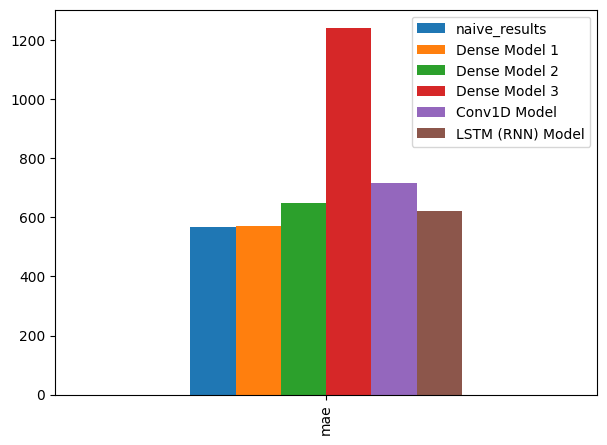

In [ ]:
model_comparision = pd.DataFrame({"naive_results" : naive_results["mae"],
                                  "Dense Model 1" : model_1_results["mae"],
                                  "Dense Model 2" : model_2_results["mae"],
                                  "Dense Model 3" : model_3_results["mae"],
                                  "Conv1D Model" :  model_4_results["mae"],
                                  "LSTM (RNN) Model" : model_5_results["mae"]} , index = ["mae"])
model_comparision.plot(kind = "bar" , figsize = (7,5)) ;

it seems with LSTM pwered RNN model we can't beat naive model results so we need to add another variable

**Make a Multivariate time-series**

as we the plot show non of our models weren't capable of beating our naive model results so we need to give our model more information .
but the information that we could feed to our model is a vague term sowe need the data that are related to our model prediction parameter that is bitcoin price

`Bitcoin Block Reward Size` is a related parameter that we want to feed to our model this determines the number of  bitcoins someone recieves from mining a bitcoin block and as times apsses from 2009 to 2012 it got a half value


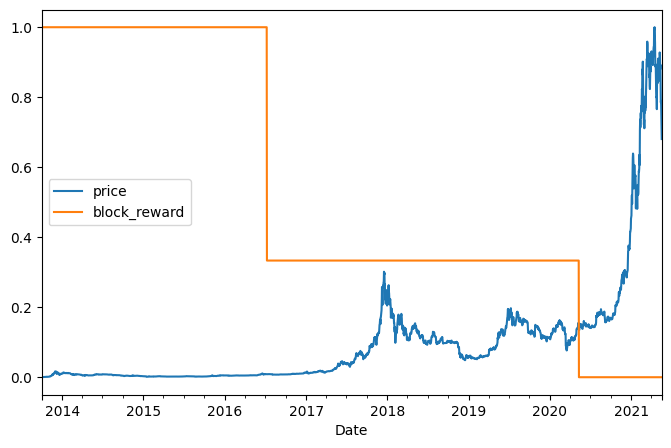

In [ ]:
# So Let's make a multivariate time-series
# Firstly making variables
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Then making datetime vriables
# Note : as 50 scale is related to back to the 2012 we won't have that in our daiagram
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Finding total times
block_reward_2_days = (block_reward_3_datetime - bitcoin_price.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_price.index[0]).days

# Manipulating DataFrame for adding block_reward column
bitcoin_price_block_reward = bitcoin_price.copy() # Note : we use copy for preventing pointing of new variable to the last variaable
bitcoin_price_block_reward["block_reward"] = None # adding a column called "blocked_reward" to table
bitcoin_price_block_reward.iloc[:block_reward_2_days , -1] = block_reward_2
bitcoin_price_block_reward.iloc[block_reward_2_days:block_reward_3_days , -1] = block_reward_3
bitcoin_price_block_reward.iloc[block_reward_3_days: , -1] = block_reward_4

# plotting by the way putting data in DataFrame
# Note : as the scale of the features that we want to add to our model is diffrent from the last features we would scale them to a sclae of between (0,1)
from sklearn.preprocessing import minmax_scale
block_reward_df = pd.DataFrame(minmax_scale(bitcoin_price_block_reward[["price","block_reward"]]),
                               columns = bitcoin_price_block_reward.columns ,
                               index = bitcoin_price_block_reward.index)
block_reward_df.plot(figsize = (8,5)) ;

❗ **Note**

if you are looking for more details of what does actully `minmax_scale` does you could use :

* [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/0.15/modules/generated/sklearn.preprocessing.MinMaxScaler.html#:~:text=Standardizes%20features%20by%20scaling%20each,i.e.%20between%20zero%20and%20one.)

* [What is MinMaxScaler ?](https://databasecamp.de/en/ml/minmax-scaler-en#:~:text=It%20scales%20the%20features%20of,has%20varying%20scales%20or%20outliers.)

**Create a Windowed Multivariate time series dataset**

for Creating a windowed Multivariate dataset we do the flolowing tasks :

1. Using `pd.DataFrame.shift()` method for shifting **columns** for a specified number

2. Removing rows with  `Nan` values

In [ ]:
# Create a copy of bitcion_price_block_reward
bitcoin_price_block_windowed = bitcoin_price_block_reward.copy()
# setting up hyperparameters
WINDOW_SIZE = 7
HORIZON_SIZE = 1

# Adding windowed columns
for i in range(WINDOW_SIZE) :
  bitcoin_price_block_windowed[f"Price + {i+1}"] = bitcoin_price_block_windowed["price"].shift(periods = i+1)

bitcoin_price_block_windowed.head(10)

,price,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Seprating X and y values by Droping Nan Values and other manipulation
X = bitcoin_price_block_windowed.dropna().drop("price" , axis = 1).astype(np.float32)
y = bitcoin_price_block_windowed.dropna()["price"].astype(np.float32)
X.head()

,block_reward,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: price, dtype: float32

In [ ]:
# Making train and test datasets
split_border = int((len(X))*0.8)
X_train , y_train = X[:split_border] , y[:split_border]
X_test , y_test = X[split_border:] , y[split_border:]

len(X) , len(X_train) , len(X_test)

(2780, 2224, 556)

In [ ]:
X_train.iloc[0] , y_train.iloc[0]

(block_reward     25.000000
 Price + 1       121.794998
 Price + 2       120.655327
 Price + 3       121.338661
 Price + 4       118.674660
 Price + 5       108.584831
 Price + 6       125.455002
 Price + 7       123.654991
 Name: 2013-10-08 00:00:00, dtype: float32,
 123.033)

### 2.6 Model 6: Dense Model

**multivariate time series**

>We use same artichecture as `model_1` for our model to calculate how much adding parameters to our model would effect it's results

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128 , activation = "relu") ,
    tf.keras.layers.Dense(32 , activation = "relu") ,
    tf.keras.layers.Dense(HORIZON_SIZE)
] ,name = "model_6")

# Compile model
model_6.compile(
    loss = tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam()
)

# Fit model
model_6.fit(x = X_train ,
            y = y_train ,
            epochs = 100 ,
            batch_size = 128 ,
            validation_data = (X_test , y_test) ,
            callbacks = [create_model_checkpoint(model_name = model_6.name)])

Epoch 1/100
18/18 [==============================] - 2s 44ms/step - loss: 2246.8965 - val_loss: 3836.4897
Epoch 2/100
18/18 [==============================] - 0s 28ms/step - loss: 331.7397 - val_loss: 1670.5907
Epoch 3/100
18/18 [==============================] - 1s 49ms/step - loss: 223.9532 - val_loss: 1275.1888
Epoch 4/100
18/18 [==============================] - 1s 30ms/step - loss: 191.8327 - val_loss: 1099.9800
Epoch 5/100
18/18 [==============================] - 1s 30ms/step - loss: 183.4244 - val_loss: 1015.4194
Epoch 6/100
18/18 [==============================] - 0s 27ms/step - loss: 177.5585 - val_loss: 983.9827
Epoch 7/100
18/18 [==============================] - 0s 27ms/step - loss: 168.7518 - val_loss: 943.0371
Epoch 8/100
18/18 [==============================] - 0s 27ms/step - loss: 161.8542 - val_loss: 888.7078
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 159.2702 - val_loss: 903.7031
Epoch 10/100
18/18 [==============================] - 0s 28

In [ ]:
# Rebound model to its best performance
model_6_loaded = tf.keras.models.load_model("Experiments/model_6")
# Make Prediction
model_6_pred = make_pred(model = model_6 , evaluation_data = X_test)
# Evaluate model
model_6_results = evaluate_preds(y_true = np.asarray(y_test) ,
                                 y_pred = model_6_pred.numpy())
model_6_results

{'mae': 684.01965,
 'mse': 1414087.6,
 'rmse': 1189.1542,
 'mape': 3.1831205,
 'mase': 0.73125637}

In [ ]:
np.asarray(y_test).shape == model_6_pred.numpy().shape

True

*Do the Excersises*

### 2.7 Model 7 : N-BEATS

**Neural Basis Expansion Analysis for interpretable Time-Series forecasting**

as one of best ways to improve model performance is increasing model layers we tend to use N-BEATS algorithms to decrease model error

then we are going to replicate **generic architecture** of N-BEATS algorithms
![Schematic of N-BEATS Algorithms](https://www.mlq.ai/content/images/2022/11/Screen-Shot-2022-11-18-at-11.11.52-AM.png)

in the other hand what we  are going to :

* Create a custom layer by subclassing `tf.keras.layer.Layer` because Tensorflow doesn't have layer implementation for us (custom layer confoguration )

*


**Creating N-BEATS Block layer**

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer) :
  def __init__(self ,
               input_size : int ,
               theta_size : int ,
               horizon : int ,
               n_neurons : int ,
               n_layers : int ,
               **kwargs) :
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.layers = n_layers

    # Creating hidden layers
    self.hidden = [tf.keras.layers.Dense(n_neurons , activation = "relu", name = f"layer_{i}") for i in range(n_layers)]

    # Creating theta layer
    self.theta_layer = tf.keras.layers.Dense(theta_size , activation = "linear" , name = "theta_layer")

  def call(self , inputs) :
    x = inputs
    for layer in self.hidden :
      x = layer(x)

    theta = self.theta_layer(x)

    # defining backcast and forecast
    backcast , forecast = theta[: , : self.input_size] , theta[: , -self.horizon:]
    return backcast , forecast

❗ **Note**

* `**kwargs` - kwargs in Python is a special syntax that allows you to pass a keyworded, variable-length argument dictionary to a function

* `__init__()` - Constructor of class (contaning : hidden layers , theta layer (output layer) , creating class attributes )

* `super().__init__()` - The super() function is often used with the __init__() method to initialize the attributes of the parent class

* `call` - this methods calls the function that happens when we pass input to the class

In [ ]:
# let's make a test case on N-BEATS created block layer
# 0. create test input and hyperparameters
test_input_n_beats = tf.random.uniform([1,WINDOW_SIZE]).numpy()
WINDOW_SIZE = 7
HORIZON_SIZE = 1

# 1. make a sample of class
test_n_beats = NBeatsBlock(input_size=WINDOW_SIZE ,
                           theta_size = WINDOW_SIZE+HORIZON_SIZE , #
                           horizon = HORIZON_SIZE ,
                           n_layers = 4 ,
                           n_neurons = 128)

# 2. calling class
back_cast , fore_cast = test_n_beats(test_input_n_beats)

# 3. printing out results
print(f"Backcast  : {back_cast.numpy().round(4)}  shape  : {back_cast.numpy().shape}  (WINDOW_SIZE) ")
print(f"Forecast : {fore_cast.numpy()}   shape  :  {fore_cast.numpy().shape}  (HORIZON_SIZE)")

Backcast  : [[ 0.0103 -0.0255  0.062  -0.0769  0.0442  0.0662  0.0087]]  shape  : (1, 7)  (WINDOW_SIZE) 
Forecast : [[-0.000625]]   shape  :  (1, 1)  (HORIZON_SIZE)


**Preparig data for N-BEATS algorithms using `tf.data`**

as our model is going to be much larger we tend to increase model speed so we use `tf.data` API for presenting our dataset

and as N-BEATS algoritms is focused on uninvariate time-series models we are going to create train and test windowed dataset as the last time we've done

🗒 **Summary**

1. Making windows and lables using `for` loop and `dropna()` method

2. Seperating windows and lables using specified columns

3. Spliting train and test datasets

In [ ]:
# Making Windows and lables
bitcoin_price_n_beats = bitcoin_price.copy()

for i in range(WINDOW_SIZE) :
  bitcoin_price_n_beats[f"Price + {i+1}"] = bitcoin_price_n_beats["price"].shift(periods=i+1)

# Seprating Windows and lables
X = bitcoin_price_n_beats.dropna().drop("price" , axis = 1)
y = bitcoin_price_n_beats.dropna()["price"]

# Making train and test splits
split_border = int((len(X)*0.8))

X_train , y_train = X[:split_border] , y[:split_border]
X_test , y_test = X[split_border:] , y[split_border:]

🗒 **Summary**

1. Turning train and test arrays into `tf.data.Dataset`

2. combining features and lables into same variables using `tf.data.Dataset.zip`

3. batching and prefetching datasets using `.batch()` and `.prefetch()` methods

In [ ]:
# 1. Turn train and test arrays into tensor datasets
train_features = tf.data.Dataset.from_tensor_slices(X_train)
train_lables = tf.data.Dataset.from_tensor_slices(y_train)
test_features = tf.data.Dataset.from_tensor_slices(X_test)
test_lables = tf.data.Dataset.from_tensor_slices(y_test)

# 2. combine features and lables
train_dataset = tf.data.Dataset.zip((train_features , train_lables))
test_dataset = tf.data.Dataset.zip((test_features , test_lables))

# 3. Batch and Prefetch  for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset , test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

**Setting up hyperprarameters for N-BEATS**

❗ **Note**

there is different varients of N-BEATS  and we are using hyperparameters valuse mentioned for `N-BEATS-G` which stands for **generic N-BEATS**
![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACK = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON_SIZE

**Taking a look at residual layers**

subtract and add tensorflow layers are what makes N-BEATS **double residual stacking**

In [ ]:
# making test variables
test_tensor_1 = tf.range(10) + 1
test_tensor_2 = tf.range(10) + 11

# implementing residual and add layers
residual_result = tf.keras.layers.subtract([test_tensor_1 , test_tensor_2])
add_result = tf.keras.layers.add([test_tensor_1 , test_tensor_2])

# printing out the results
print(f"tensor 1 : {test_tensor_1}")
print(f"tensor 2 : {test_tensor_2}")
print(f"residual layer result : {residual_result}")
print(f"adding layer result : {add_result}")

tensor 1 : [ 1  2  3  4  5  6  7  8  9 10]
tensor 2 : [11 12 13 14 15 16 17 18 19 20]
residual layer result : [-10 -10 -10 -10 -10 -10 -10 -10 -10 -10]
adding layer result : [12 14 16 18 20 22 24 26 28 30]


**Building , comiling and fitting N-BEATS algorithms**

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)

# 1. Create Input layer
inputs = tf.keras.layers.Input(shape = (INPUT_SIZE) , name = "input_layer")

# 2. setting parameters for model
residual = 0
forecast = 0
backcast = 0

# 3. Create Stack Blocks
for i , _ in enumerate(range(N_STACK)) :
  if i == 0 :
    backcast , forecast = NBeatsBlock(
                                     input_size = INPUT_SIZE ,
                                     theta_size = THETA_SIZE ,
                                     horizon = HORIZON_SIZE ,
                                     n_layers = N_LAYERS ,
                                     n_neurons = N_NEURONS)(inputs)
    residual = tf.keras.layers.subtract([inputs , backcast] , name = f"subtract_{i}")
  else :
    block_backcast , block_forecast = NBeatsBlock(
                                     input_size = INPUT_SIZE ,
                                     theta_size = THETA_SIZE ,
                                     horizon = HORIZON_SIZE ,
                                     n_layers = N_LAYERS ,
                                     n_neurons = N_NEURONS)(residual)

    residual = tf.keras.layers.subtract([residual , block_backcast] , name = f"subtract_{i}")
    forecast = tf.keras.layers.add([forecast , block_forecast] , name = f"add_{i}")

# 4. Creating model
model_7 = tf.keras.Model(inputs = inputs ,
                         outputs = forecast ,
                         name = "model_7")

# 5. Compiling model
model_7.compile(loss = tf.keras.losses.mean_absolute_error ,
                optimizer = tf.keras.optimizers.Adam(0.001) ,
                metrics = ["mse"])

# 6. Fit model
model_7.fit(train_dataset ,
            epochs = N_EPOCHS ,
            validation_data = test_dataset ,
            verbose = 0 ,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss" , patience  = 200 , restore_best_weights = True) ,
                         tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss" , patience = 100 , verbose = 1)])


Epoch 331: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 431: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [ ]:
# Make predictions with model
model_7_preds = make_pred(model_7 , test_dataset)
# Evaluate predictions
model_7_results = evaluate_preds(y_true = list(test_dataset.as_numpy_iterator())[0][1],
                                 y_pred = model_7_preds.numpy())

model_7_results

{'mae': 570.73285,
 'mse': 1110939.6,
 'rmse': 1054.0112,
 'mape': 2.6854093,
 'mase': 0.6893953}

In [ ]:
# checking for model prediction shape and test dataset
model_7_preds.numpy().shape == list(test_dataset.as_numpy_iterator())[0][1].shape

True

❗ **Note**

we could use `as_numpy_iterator` method to inspect content of dataset but we must remember that output of method is from *generator* type

In [ ]:
# save model for further using
model_7.save(model_7.name)

🔑 **Key**

as this large model hand-crafted we didn't achived the accuracy of `model_1` or `model_0` and as a result we could conclude that all large models are not good models

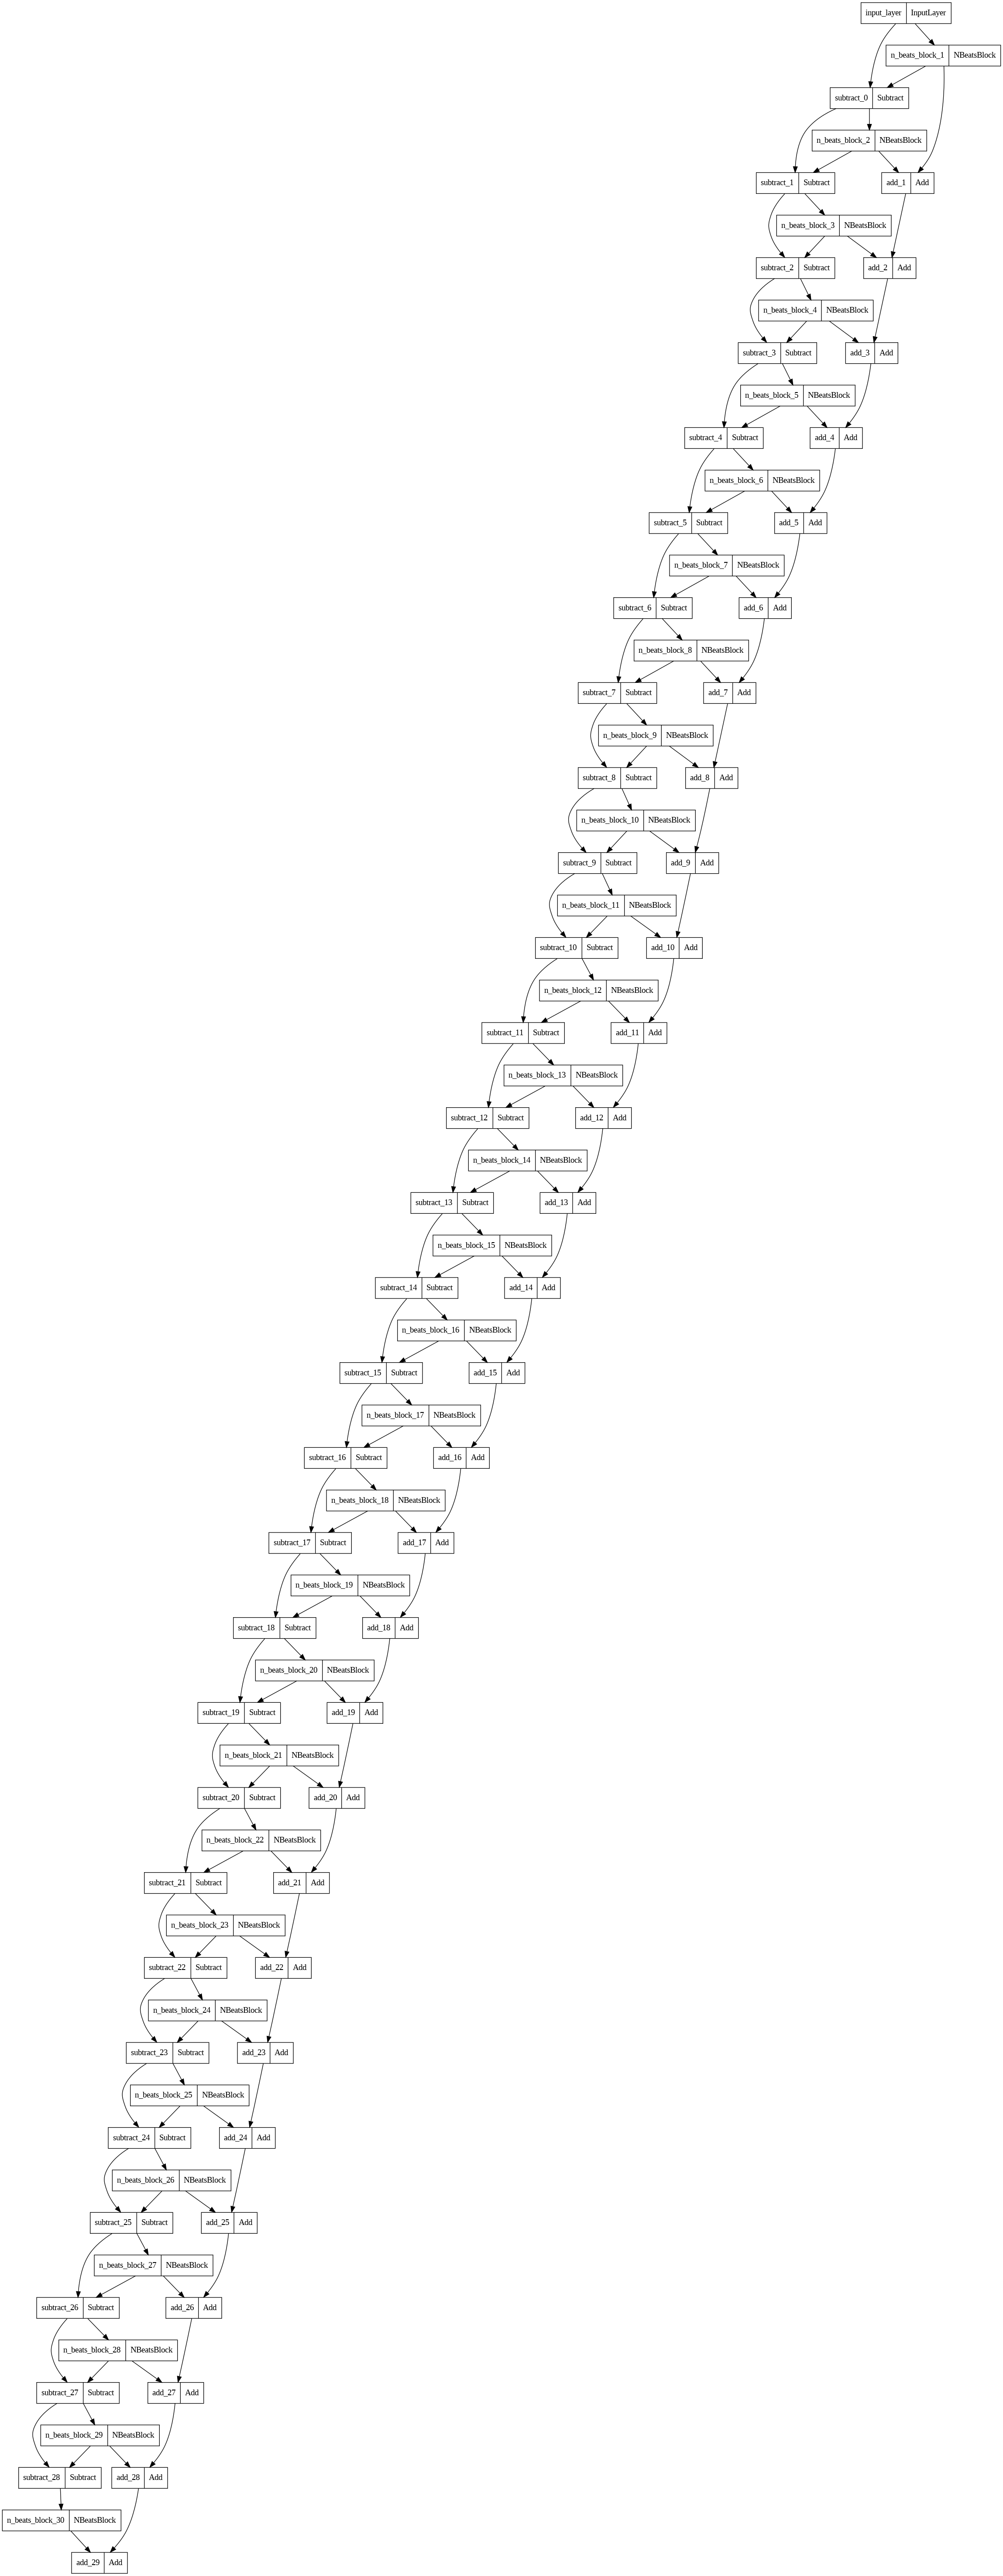

In [ ]:
# plotting model diagram
plot_model(model_7)

for further understanding of N-BEATS model we could see figure below

![Relating model_7 plot with N-BEATS diagram](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-stack-model-vs-nbeats-architecture.png)


🔑 **Key**

N-BEATS paper used mutiple of models to make predictions but  we only replicates generic artichecture of N-BEATS for further artichectures of N-BAETS we could use N-BEATS appendix papers

### 2.8 Model 8: Ensemble of models

(stacking different models together)

As the expriments about N-BEATS model failed we remember our motto :
> expreiment , expreiment , expreiment

an **ensemble** invlolves training and combining multiple different models on same problem .

by using ensemble of models we reach a higher **smart level** for our model , in another word rather than relying on single model predictions's we can take average or median of diffrent models' prediction .

**Combined predictive power** of ensembled models is better than single model


to create our ensemble models we are going to be using a combination of :

* Different loss function
* Randomly initialized models

with ensembles as we have better performance we would have :

* more **training time**
* more **prediction time**



**Constructing and fitting an ensemble of models(using different loss function)**

In [ ]:
def get_ensemble_model(horizon = HORIZON_SIZE ,
                       train_data = train_dataset ,
                       test_data = test_dataset ,
                       num_iter = 10 ,
                       num_epochs = 100 ,
                       loss_fns = ["mae" , "mse" , "mape"]) :
    """


    """

    ensemble_model = []

    for i in range(num_iter) :
      for loss_function in loss_fns :
        # 1 . Create model
        print(f"Optimizing model by reducing {loss_function} for {num_epochs} epochs , model_number : {i}")
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128 , kernel_initializer = "he_normal" , activation = "relu") ,
            tf.keras.layers.Dense(128 , kernel_initializer = "he_normal" , activation = "relu") ,
            tf.keras.layers.Dense(HORIZON_SIZE) ,
        ] , name = f"model_{i}_{loss_function}")

        # 2. Compile model
        model.compile(loss = loss_function ,
                      optimizer = tf.keras.optimizers.Adam() ,
                      metrics = ["mae" , "mse"])

        # 3. Fit model
        model.fit(train_data ,
                  epochs = num_epochs ,
                  verbose = 0 ,
                  validation_data = test_data ,
                  callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss" ,
                                                                patience = 200 ,
                                                                restore_best_weights = True) ,
                               tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss" ,
                                                                    patience = 100 ,
                                                                    verbose = 1)])

        # append trained model
        ensemble_model.append(model)

    return ensemble_model

**the fllowing steps are :**

1. making an ensemble of models with total number of 15 models
2. making predictions with ensemble of models
3. evaluating results of ensemble

In [ ]:
# 1 . make an ensembled model
ensemble_models = get_ensemble_model(num_iter = 5 ,
                                    num_epochs = 1000)

Optimizing model by reducing mae for 1000 epochs , model_number : 0

Epoch 934: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000 epochs , model_number : 0

Epoch 589: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 689: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000 epochs , model_number : 0

Epoch 179: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 657: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 757: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing mae for 1000 epochs , model_number : 1

Epoch 701: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000 epochs , model_number : 1

Epoch 781: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 881: ReduceL

In [ ]:
# 2 . make prediction with ensemble model
def make_ensemble_preds(ensemble_model , data) :
  ensemble_preds = []
  for model in ensemble_model :
    preds = model.predict(data)
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

ensemble_preds = make_ensemble_preds(ensemble_model = ensemble_models ,
                                     data = test_dataset)

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


In [ ]:
# 3 . evaluating our ensembles predictions
ensemble_results = evaluate_preds(y_true = y_test,
                                  y_pred = np.median(ensemble_preds , axis = 0))

ensemble_results

{'mae': 566.0967,
 'mse': 1143340.4,
 'rmse': 1069.271,
 'mape': 2.5657308,
 'mase': 0.6921734}

**Plotting prediction intervals (uncertanity of ensembles)**

the best description of uncertainity of ensembles can be infered from [daniel brouke github note book](https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb#scrollTo=rerdvQAdFptN)

> as **point predictions** are almost always going to be wrong . so having a range of values can help with decision making .

> these king of predictions are called **prediction intervals** or **uncertanity estimates** and they are as import as forecast itself .

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

1. Make predictions on a number of randomly initialized models
2. Measure Standard deviation of predictions
3. Multiply standard deviation by `1.96`
4. for finding upper and lower bounds of predictions add and subtract predictions of point prediction models

In [ ]:
# finding upper and lower values of predictions
def upper_lower_calculate(preds) :
  # 1. finding standard deviation
  std = tf.math.reduce_std(preds)
  # 2. multiply by a specified value
  interval = 1.96 * std
  # 3. finding mean value
  preds_mean = tf.reduce_mean(preds , axis = 0)
  lower , upper = preds_mean - interval , preds_mean + interval
  # 4. returning extracted results
  return upper , lower

upper , lower = upper_lower_calculate(ensemble_preds)

**plotting prediction intervals**

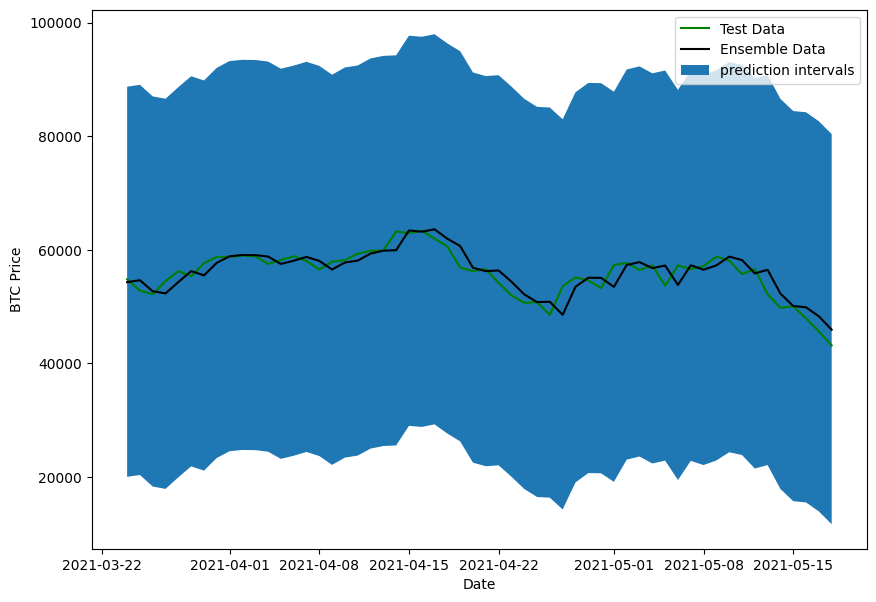

In [ ]:
ensemble_median = np.median(ensemble_preds , axis = 0)

offset = 500

plt.figure(figsize = (10,7))
plt.plot(X_test.index[offset:] , y_test[offset:] ,"g",label = "Test Data") ;
plt.plot(X_test.index[offset:] , ensemble_median[offset:] ,"k-",label = "Ensemble Data") ;
plt.xlabel("Date") ;
plt.ylabel("BTC Price") ;
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:] ,
                 (upper)[offset:] , label = "prediction intervals") ;
plt.legend() ;

$$\frac{a}{b}$$
